# Entrenamiento y Comparación de Modelos ML - CTU-13 Botnet Detection

Este notebook entrena y compara 4 modelos de Machine Learning para detectar botnets en logs de Zeek del dataset CTU-13:

- **Random Forest** (Ensemble - Bagging)
- **XGBoost** (Ensemble - Boosting)
- **Regresión Logística** (Modelo Lineal)
- **Red Neuronal (MLP)** (Deep Learning)

## Dataset: CTU-13
Logs de tráfico de red capturados con Zeek, etiquetados con IPs de botnets conocidas (Neris, Rbot, Virut, etc.)

## 1. Configuración e Importaciones

## Configuración Rápida

**ANTES DE EJECUTAR**: Modifica esta variable en la siguiente celda:

**`SCENARIO_NUMBER`**: Número del escenario CTU-13 que vas a analizar (2, 3, 9 o 10)

El notebook usará las estadísticas reales del dataset CTU-13 según el paper oficial.

In [127]:
# Importaciones
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix,
    classification_report
)
import pickle
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

print("Librerías importadas correctamente")

Librerías importadas correctamente


In [128]:
# Configuración global
TEST_SIZE = 0.3
RANDOM_STATE = 42

# Número de escenario CTU-13 que estás usando (2,3,9,10)
SCENARIO_NUMBER = 9
LOG_FILE = f'./escenario{SCENARIO_NUMBER}_ctu13/conn.log' 

# Datos reales del dataset CTU-13 (según paper oficial)
CTU13_STATS = {
    1: {'total': 2824636, 'botnet': 39933, 'normal': 30387, 'cc': 1026, 'background': 2753290, 'bot_type': 'Neris', 'num_bots': 1},
    2: {'total': 1808122, 'botnet': 18839, 'normal': 9120, 'cc': 2102, 'background': 1778061, 'bot_type': 'Neris', 'num_bots': 1},
    3: {'total': 4710638, 'botnet': 26759, 'normal': 116887, 'cc': 63, 'background': 4566929, 'bot_type': 'Rbot', 'num_bots': 1},
    4: {'total': 1121076, 'botnet': 1719, 'normal': 25268, 'cc': 49, 'background': 1094040, 'bot_type': 'Rbot', 'num_bots': 1},
    5: {'total': 129832, 'botnet': 695, 'normal': 4679, 'cc': 206, 'background': 124252, 'bot_type': 'Virut', 'num_bots': 1},
    6: {'total': 558919, 'botnet': 4431, 'normal': 7494, 'cc': 199, 'background': 546795, 'bot_type': 'Menti', 'num_bots': 1},
    7: {'total': 114077, 'botnet': 37, 'normal': 1677, 'cc': 26, 'background': 112337, 'bot_type': 'Sogou', 'num_bots': 1},
    8: {'total': 2954230, 'botnet': 5052, 'normal': 72822, 'cc': 1074, 'background': 2875282, 'bot_type': 'Murlo', 'num_bots': 1},
    9: {'total': 2753884, 'botnet': 179880, 'normal': 43340, 'cc': 5099, 'background': 2525565, 'bot_type': 'Neris', 'num_bots': 10},
    10: {'total': 1309791, 'botnet': 106315, 'normal': 15847, 'cc': 37, 'background': 1187592, 'bot_type': 'Rbot', 'num_bots': 10},
    11: {'total': 107251, 'botnet': 8161, 'normal': 2718, 'cc': 3, 'background': 96369, 'bot_type': 'Rbot', 'num_bots': 3},
    12: {'total': 325471, 'botnet': 2143, 'normal': 7628, 'cc': 25, 'background': 315675, 'bot_type': 'NSIS.ay', 'num_bots': 3},
    13: {'total': 1925149, 'botnet': 38791, 'normal': 31939, 'cc': 1202, 'background': 1853217, 'bot_type': 'Virut', 'num_bots': 1}
}

# IPs de bots conocidas por escenario CTU-13
known_bots = {
    1: ['147.32.84.165'],  # Neris
    2: ['147.32.84.165'],  # Neris
    3: ['147.32.84.165'],  # Rbot
    4: ['147.32.84.165'],  # Rbot
    5: ['147.32.84.165'],  # Virut
    6: ['147.32.84.165'],  # Menti
    7: ['147.32.84.165'],  # Sogou
    8: ['147.32.84.165'],  # Murlo
    9: ['147.32.84.165', '147.32.84.191', '147.32.84.192', 
            '147.32.84.193', '147.32.84.204', '147.32.84.205', 
            '147.32.84.206', '147.32.84.207', '147.32.84.208', '147.32.84.209'],  # Neris (10 bots)
    10: ['147.32.84.191', '147.32.84.192', '147.32.84.193', 
            '147.32.84.204', '147.32.84.205', '147.32.84.206', 
            '147.32.84.207', '147.32.84.208', '147.32.84.209'],  # Rbot (10 bots)
    11: ['147.32.84.165', '147.32.84.191', '147.32.84.192'],  # Rbot (3 bots)
    12: ['147.32.84.165', '147.32.84.191', '147.32.84.192'],  # NSIS.ay (3 bots)
    13: ['147.32.84.165']  # Virut
    }

scenario_info = CTU13_STATS[SCENARIO_NUMBER]
print(f"Escenario CTU-13 #{SCENARIO_NUMBER}")
print(f"  Bot: {scenario_info['bot_type']} ({scenario_info['num_bots']} bot(s))")
print(f"  Dataset completo: {scenario_info['total']:,} flujos totales")
print(f"    - Botnet: {scenario_info['botnet']:,} ({scenario_info['botnet']/scenario_info['total']*100:.3f}%)")
print(f"    - Normal: {scenario_info['normal']:,} ({scenario_info['normal']/scenario_info['total']*100:.3f}%)")
print(f"    - C&C:    {scenario_info['cc']:,} ({scenario_info['cc']/scenario_info['total']*100:.3f}%)")
print(f"    - Fondo:  {scenario_info['background']:,} ({scenario_info['background']/scenario_info['total']*100:.3f}%)")
print(f"\nArchivo de log: {LOG_FILE}")
print(f"Split: {int((1-TEST_SIZE)*100)}% train / {int(TEST_SIZE*100)}% test")
print(f"Random state: {RANDOM_STATE}")


Escenario CTU-13 #9
  Bot: Neris (10 bot(s))
  Dataset completo: 2,753,884 flujos totales
    - Botnet: 179,880 (6.532%)
    - Normal: 43,340 (1.574%)
    - C&C:    5,099 (0.185%)
    - Fondo:  2,525,565 (91.709%)

Archivo de log: ./escenario9_ctu13/conn.log
Split: 70% train / 30% test
Random state: 42


## 2. Funciones Auxiliares

In [129]:
def label_ctu13_bots(df, scenario):
    """
    Etiqueta las IPs conocidas de botnets en los datasets CTU-13.
    """
    
    # Etiquetar malware
    if scenario in known_bots:
        bot_ips = known_bots[scenario]
        malware_count = df['id.orig_h'].isin(bot_ips).sum()
        
        if malware_count > 0:
            df.loc[df['id.orig_h'].isin(bot_ips), 'label'] = 'malware'
            print(f"   {malware_count:,} flujos etiquetados como 'malware'")
            print(f"   IPs bot: {', '.join(bot_ips)}")
        else:
            print(f"   ADVERTENCIA: No se encontraron las IPs esperadas del escenario {scenario}")
    else:
        print(f"   ERROR: Escenario {scenario} no válido (debe ser 1-13)")
    
    return df

print("Función de etiquetado definida")


Función de etiquetado definida


In [130]:
def get_model_metrics(model, X_test, y_test, model_name, use_scaled=False, scaler=None):
    """
    Calcula todas las métricas para un modelo.
    """
    # Aplicar scaling si es necesario
    if use_scaled and scaler is not None:
        X_eval = scaler.transform(X_test)
    else:
        X_eval = X_test
    
    # Predicciones
    y_pred = model.predict(X_eval)
    
    # Probabilidades para AUC-ROC
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_eval)[:, 1]
    else:
        y_proba = None
    
    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm[0, 0], cm[0, 1], cm[1, 0], cm[1, 1]
    
    # Calcular tasas de error
    total_normal = tn + fp
    total_malware = fn + tp
    fp_rate = (fp / total_normal * 100) if total_normal > 0 else 0
    fn_rate = (fn / total_malware * 100) if total_malware > 0 else 0
    
    # Calcular métricas
    metrics = {
        'model': model_name,
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, zero_division=0),
        'recall': recall_score(y_test, y_pred, zero_division=0),
        'f1': f1_score(y_test, y_pred, zero_division=0),
        'roc_auc': roc_auc_score(y_test, y_proba) if y_proba is not None else None,
        'confusion_matrix': cm,
        # Valores absolutos
        'tn': tn,
        'fp': fp,
        'fn': fn,
        'tp': tp,
        # Tasas de error
        'fp_rate': fp_rate,
        'fn_rate': fn_rate
    }
    
    return metrics

print("Función de métricas definida")

Función de métricas definida


## 3 Carga y Limpieza de Datos

In [131]:
print("[1/6] Cargando logs de Zeek...\n")

# Intentar cargar el fichero de logs 
try:
    df = pd.read_json(LOG_FILE, lines=True)
    
    # Renombrar columnas si es necesario
    if 'id.orig_h' not in df.columns and 'id_orig_h' in df.columns:
        column_mapping = {
            'id_orig_h': 'id.orig_h',
            'id_orig_p': 'id.orig_p',
            'id_resp_h': 'id.resp_h',
            'id_resp_p': 'id.resp_p'
        }
        df.rename(columns=column_mapping, inplace=True)
    print("   Archivo cargado en formato JSON")
except ValueError as e:
    print(e)
    


print(f"\nDataset cargado: {df.shape[0]:,} filas × {df.shape[1]} columnas")
df.head()

[1/6] Cargando logs de Zeek...

   Archivo cargado en formato JSON

Dataset cargado: 160,011 filas × 21 columnas


,ts,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,duration,orig_bytes,resp_bytes,...,local_orig,local_resp,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,community_id,orig_mac_oui
0,1.761739e+09,CSiWHu6gQZYx8tjm9,147.32.84.132,63432,69.171.224.11,80,tcp,64.986979,21137.0,42146.0,...,False,False,0,AaFf,32,1280,5,200,1:eVpXV8PfZywDzixuUu1ncAQgQ2I=,"Cisco Systems, Inc"
1,1.761739e+09,C1nnhj2hvn8ofT70Ti,147.32.84.132,63523,69.171.224.11,80,tcp,25.215306,4144.0,0.0,...,False,False,0,AFaf,11,440,2,80,1:i55ZRd8WnJqQ99GEwH8hJmhJSjM=,"Cisco Systems, Inc"
2,1.761739e+09,Cxllge11EIzmjsFyqi,147.32.86.165,59826,194.79.52.199,80,tcp,38.074051,3741.0,3132.0,...,False,False,0,AaFR,12,480,2,80,1:az+BZHCcvMC/vC+Ol5ttTbQx5+s=,"Cisco Systems, Inc"
3,1.761739e+09,C9L2SdUHj4IDd4UOh,147.32.86.20,4934,87.98.230.229,80,tcp,0.006538,143.0,57104.0,...,False,False,0,AaF,20,800,3,120,1:sksnVr5IXMGbhUrtlEVPVXJM1+U=,"Cisco Systems, Inc"
4,1.761739e+09,CtK9jG132Qd16XIvy9,147.32.86.194,1481,74.125.232.220,80,tcp,0.149965,2328.0,48340.0,...,False,False,0,AaFf,25,1000,2,80,1:WB1uzbdqLMC3xn2ZnY4xyErJEYk=,"Cisco Systems, Inc"


In [132]:
print("[2/6] Limpiando datos de Zeek...\n")

# Limpiar columnas numéricas (Zeek usa '-' para valores faltantes)
numeric_columns = [
    ('orig_bytes', 'int64'),
    ('resp_bytes', 'int64'),
    ('resp_pkts', 'int64'),
    ('orig_ip_bytes', 'int64'),
    ('resp_ip_bytes', 'int64'),
    ('duration', 'float64'),
    ('id.resp_p', 'int64'),
    ('orig_pkts', 'int64')
]

for col_name, col_type in numeric_columns:
    if col_name in df.columns:
        df.replace({col_name: '-'}, '0', inplace=True)
        df[col_name] = pd.to_numeric(df[col_name], errors='coerce')
        df[col_name] = df[col_name].fillna(0).astype(col_type)

# ip_proto
if 'ip_proto' not in df.columns:
    df['ip_proto'] = 0
else:
    df.replace({'ip_proto': '-'}, '0', inplace=True)
    df['ip_proto'] = pd.to_numeric(df['ip_proto'], errors='coerce')
    df['ip_proto'] = df['ip_proto'].fillna(0).astype('int64')

# Crear columna datetime
df['datetime'] = pd.to_datetime(df['ts'], unit='s')

# Crear columna label
if 'label' not in df.columns:
    df['label'] = 'normal'
    print("   Columna 'label' creada (todos inicializados como 'normal')")

print(f"   {len(df):,} flujos de red procesados")

# Rango temporal
time_range = (df['datetime'].max() - df['datetime'].min()).total_seconds() / 60
print(f"   Rango temporal: {time_range:.2f} minutos")

[2/6] Limpiando datos de Zeek...

   Columna 'label' creada (todos inicializados como 'normal')
   160,011 flujos de red procesados
   Rango temporal: 44.07 minutos


[3/6] Etiquetando botnets conocidas del CTU-13...

   28,996 flujos etiquetados como 'malware'
   IPs bot: 147.32.84.165, 147.32.84.191, 147.32.84.192, 147.32.84.193, 147.32.84.204, 147.32.84.205, 147.32.84.206, 147.32.84.207, 147.32.84.208, 147.32.84.209

Distribución de clases en el subset cargado:
label
normal     131015
malware     28996
Name: count, dtype: int64

────────────────────────────────────────────────────────────
INFO DEL DATASET COMPLETO (Escenario 9):
  Total:   2,753,884 flujos
  Botnet:  179,880 (6.53%)
  Normal:  43,340 (1.57%)
  C&C:     5,099 (0.19%)
  Fondo:   2,525,565 (91.71%)
────────────────────────────────────────────────────────────


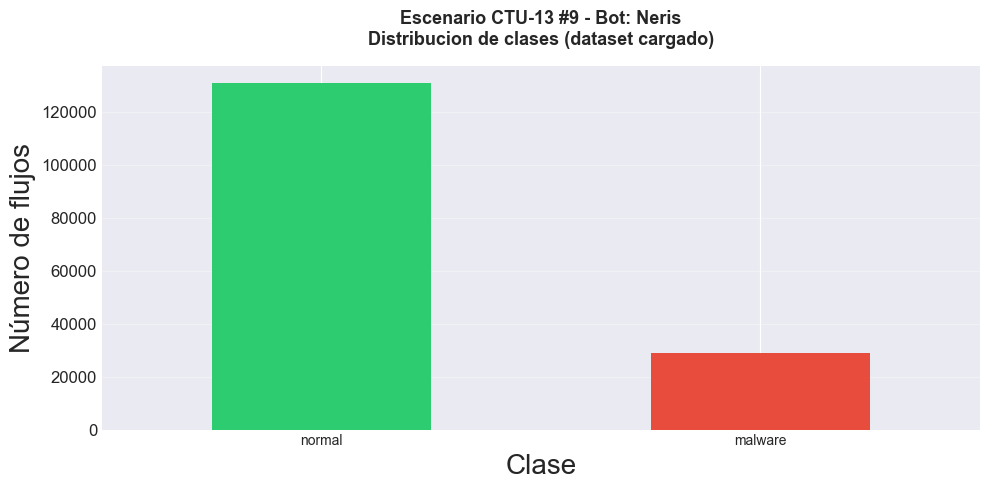

In [155]:
print("[3/6] Etiquetando botnets conocidas del CTU-13...\n")

df = label_ctu13_bots(df, SCENARIO_NUMBER)

# Distribución de clases
print("\nDistribución de clases en el subset cargado:")
class_counts = df['label'].value_counts()
print(class_counts)

# Mostrar info del dataset completo
print("\n" + "─"*60)
print(f"INFO DEL DATASET COMPLETO (Escenario {SCENARIO_NUMBER}):")
print(f"  Total:   {scenario_info['total']:,} flujos")
print(f"  Botnet:  {scenario_info['botnet']:,} ({scenario_info['botnet']/scenario_info['total']*100:.2f}%)")
print(f"  Normal:  {scenario_info['normal']:,} ({scenario_info['normal']/scenario_info['total']*100:.2f}%)")
print(f"  C&C:     {scenario_info['cc']:,} ({scenario_info['cc']/scenario_info['total']*100:.2f}%)")
print(f"  Fondo:   {scenario_info['background']:,} ({scenario_info['background']/scenario_info['total']*100:.2f}%)")
print("─"*60)

# Visualización
plt.figure(figsize=(10, 5))
class_counts.plot(kind='bar', color=['#2ecc71', '#e74c3c'])
plt.title(f"Escenario CTU-13 #{SCENARIO_NUMBER} - Bot: {scenario_info['bot_type']}\nDistribucion de clases (dataset cargado)", 
          fontsize=13, fontweight='bold', pad=15)
plt.xlabel('Clase', fontsize=20)
plt.ylabel('Número de flujos', fontsize=20)
plt.xticks(rotation=0, fontsize=10)
plt.yticks(fontsize=12)
plt.ylim(bottom=0)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

if 'malware' not in class_counts or class_counts['malware'] == 0:
    print("\nADVERTENCIA: No hay flujos malware etiquetados")

## 4 Preparación de Features

In [134]:
print("[4/6] Preparando features y labels...\n")

# Excluir columnas no numéricas y identificadores
cols_to_exclude = [
    'label', 'id.orig_h', 'id.resp_h', 'id.orig_p', 'id.resp_p', 
    'uid', 'ts', 'datetime', 'proto', 'service', 'conn_state', 
    'history', 'tunnel_parents', 'community_id', 'orig_mac_oui',
    'local_orig', 'local_resp'
]

cols_to_exclude_present = [col for col in cols_to_exclude if col in df.columns]

# Crear X
X = df.drop(columns=cols_to_exclude_present)

# Asegurar que todas son numéricas
for col in X.columns:
    X[col] = pd.to_numeric(X[col], errors='coerce').fillna(0)

# Labels (0=normal, 1=malware)
y = df['label'].map({'normal': 0, 'malware': 1})

print(f"Features: {X.shape[1]} columnas numéricas")
print(f"Columnas usadas:\n   {list(X.columns)}")
print(f"\nMuestras totales: {len(X):,}")
print(f"Labels: 0=normal, 1=malware")

# Mostrar estadísticas
X.describe()

[4/6] Preparando features y labels...

Features: 9 columnas numéricas
Columnas usadas:
   ['duration', 'orig_bytes', 'resp_bytes', 'missed_bytes', 'orig_pkts', 'orig_ip_bytes', 'resp_pkts', 'resp_ip_bytes', 'ip_proto']

Muestras totales: 160,011
Labels: 0=normal, 1=malware


,duration,orig_bytes,resp_bytes,missed_bytes,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,ip_proto
count,160011.000000,1.600110e+05,1.600110e+05,1.600110e+05,160011.000000,1.600110e+05,160011.000000,1.600110e+05,160011.0
mean,11.564285,5.518253e+05,1.859257e+05,4.170866e+01,25.951285,1.038032e+03,10.083519,4.033267e+02,0.0
std,86.556953,3.519068e+07,1.727844e+07,5.482296e+03,1808.202130,7.232808e+04,1871.771662,7.487087e+04,0.0
min,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.0
25%,0.013434,0.000000e+00,0.000000e+00,0.000000e+00,3.000000,1.200000e+02,1.000000,4.000000e+01,0.0
50%,0.188940,4.640000e+02,2.670000e+02,0.000000e+00,4.000000,1.600000e+02,2.000000,8.000000e+01,0.0
75%,3.024248,1.146000e+03,3.964000e+03,0.000000e+00,7.000000,2.800000e+02,3.000000,1.200000e+02,0.0
max,2621.267679,3.927275e+09,3.969531e+09,1.270545e+06,654999.000000,2.619996e+07,745934.000000,2.983736e+07,0.0


## 5 Split Train/Test

In [135]:
print(f"Dividiendo datos (train {int((1-TEST_SIZE)*100)}% / test {int(TEST_SIZE*100)}%)...\n")

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y
)

print(f"Train: {len(X_train):,} muestras")
print(f"Test:  {len(X_test):,} muestras")

# Distribución en train/test
print(f"\nDistribución en TRAIN:")
print(pd.Series(y_train).value_counts())
print(f"\nDistribución en TEST:")
print(pd.Series(y_test).value_counts())

Dividiendo datos (train 70% / test 30%)...

Train: 112,007 muestras
Test:  48,004 muestras

Distribución en TRAIN:
label
0    91710
1    20297
Name: count, dtype: int64

Distribución en TEST:
label
0    39305
1     8699
Name: count, dtype: int64


## 6️ Entrenamiento de Modelos

### Random Forest

In [136]:
print("Entrenando Random Forest...\n")

rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=0
)

rf_model.fit(X_train, y_train)

print("Random Forest entrenado")

Entrenando Random Forest...

Random Forest entrenado


### Red Neuronal (MLP)

In [137]:
print("Entrenando Red Neuronal MLP (con StandardScaler)...\n")

# Reutilizar el scaler de la regresión logística si ya existe, o crear uno nuevo
if 'scaler' not in locals():
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
else:
    X_train_scaled = scaler.transform(X_train)

mlp_model = MLPClassifier(
    hidden_layer_sizes=(128, 64, 32),  # Capas más profundas para patrones complejos
    activation='relu',                 # Función estándar y eficiente
    solver='adam',                     # Optimizador adaptativo
    alpha=1e-4,                        # Regularización L2 (reduce overfitting)
    learning_rate='adaptive',          # Ajusta dinámicamente el learning rate
    learning_rate_init=0.001,          # Tasa inicial (puedes probar 0.0005–0.005)
    batch_size=256,                    # Tamaño de batch óptimo para 100k–200k filas
    max_iter=500,                      # Más iteraciones para convergencia estable
    early_stopping=True,               # Detiene el entrenamiento al estancarse
    validation_fraction=0.1,           # 10% del train usado para validación interna
    n_iter_no_change=20,               # Paciencia del early stopping
    random_state=RANDOM_STATE
)

mlp_model.fit(X_train_scaled, y_train)

print("Red Neuronal MLP entrenada")

Entrenando Red Neuronal MLP (con StandardScaler)...

Red Neuronal MLP entrenada


### Regresión Logística

In [138]:
print("Entrenando Regresión Logística (con StandardScaler)...\n")

# Asegurar que el scaler está creado
if 'scaler' not in locals():
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
else:
    if 'X_train_scaled' not in locals():
        X_train_scaled = scaler.transform(X_train)

lr_model = LogisticRegression(
    penalty='l2',              # Regularización Ridge (evita sobreajuste)
    C=1.0,                     # Inversa de la fuerza de regularización (ajustable)
    solver='lbfgs',            # Eficiente para datasets medianos-grandes
    class_weight='balanced',   # Compensa si hay desbalance entre clases
    max_iter=2000,             # Más iteraciones por si no converge
    random_state=RANDOM_STATE,
    n_jobs=-1
)
lr_model.fit(X_train_scaled, y_train)

print("Regresión Logística entrenada")

Entrenando Regresión Logística (con StandardScaler)...

Regresión Logística entrenada


### XGBoost

In [139]:
print("Entrenando XGBoost...\n")

xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbosity=0
)

xgb_model.fit(X_train, y_train)

print("XGBoost entrenado")
print("\n" + "="*80)
print("TODOS LOS MODELOS ENTRENADOS EXITOSAMENTE")
print("="*80)

Entrenando XGBoost...

XGBoost entrenado

TODOS LOS MODELOS ENTRENADOS EXITOSAMENTE


## 7 Evaluación de Modelos

In [140]:
print("[5/6] Evaluando modelos en conjunto de test...\n")

# Calcular métricas
rf_metrics = get_model_metrics(rf_model, X_test, y_test, 'Random Forest')
mlp_metrics = get_model_metrics(mlp_model, X_test, y_test, 'Red Neuronal (MLP)',
                                use_scaled=True, scaler=scaler)
lr_metrics = get_model_metrics(lr_model, X_test, y_test, 'Regresión Logística',
                               use_scaled=True, scaler=scaler)
xgb_metrics = get_model_metrics(xgb_model, X_test, y_test, 'XGBoost')

all_metrics = [rf_metrics, mlp_metrics, lr_metrics, xgb_metrics]

print("Métricas calculadas")

[5/6] Evaluando modelos en conjunto de test...

Métricas calculadas


### Tabla Comparativa

In [141]:
# Información sobre el dataset de test
total_normal_real = (y_test == 0).sum()
total_malware_real = (y_test == 1).sum()

print("\n" + "="*80)
print("COMPOSICIÓN DEL CONJUNTO DE TEST")
print("="*80)
print(f"\nTotal de muestras en test: {len(y_test):,}")
print(f"  - Tráfico NORMAL:  {total_normal_real:,} ({total_normal_real/len(y_test)*100:.2f}%)")
print(f"  - Tráfico MALWARE: {total_malware_real:,} ({total_malware_real/len(y_test)*100:.2f}%)")

# Crear DataFrame de métricas
metrics_df = pd.DataFrame({
    'Modelo': [m['model'] for m in all_metrics],
    'Predicho_Normal': [m['tn'] + m['fn'] for m in all_metrics],      # Todo lo que se predijo como "normal"
    'Predicho_Malware': [m['tp'] + m['fp'] for m in all_metrics],      # Todo lo que se predijo como "malware"
    'TN': [m['tn'] for m in all_metrics],  # Verdaderos Negativos (normal bien clasificado)
    'FP': [m['fp'] for m in all_metrics],  # Falsos Positivos (normal clasificado como malware)
    'FN': [m['fn'] for m in all_metrics],  # Falsos Negativos (malware clasificado como normal)
    'TP': [m['tp'] for m in all_metrics],  # Verdaderos Positivos (malware bien clasificado)
    'FP_Rate_%': [m['fp_rate'] for m in all_metrics],
    'FN_Rate_%': [m['fn_rate'] for m in all_metrics],
    'Accuracy': [m['accuracy'] for m in all_metrics],
    'Precision': [m['precision'] for m in all_metrics],
    'Recall': [m['recall'] for m in all_metrics],
    'F1-Score': [m['f1'] for m in all_metrics],
    'AUC-ROC': [m['roc_auc'] for m in all_metrics]
})

# Formatear para visualización
metrics_display = metrics_df.copy()
metrics_display['Predicho_Normal'] = metrics_display['Predicho_Normal'].astype(int)
metrics_display['Predicho_Malware'] = metrics_display['Predicho_Malware'].astype(int)
metrics_display['TN'] = metrics_display['TN'].astype(int)
metrics_display['TP'] = metrics_display['TP'].astype(int)
metrics_display['FP'] = metrics_display['FP'].astype(int)
metrics_display['FN'] = metrics_display['FN'].astype(int)
metrics_display['FP_Rate_%'] = metrics_display['FP_Rate_%'].apply(lambda x: f"{x:.2f}")
metrics_display['FN_Rate_%'] = metrics_display['FN_Rate_%'].apply(lambda x: f"{x:.2f}")
for col in ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC']:
    metrics_display[col] = metrics_display[col].apply(lambda x: f"{x:.4f}" if pd.notna(x) else "N/A")

print("\n" + "="*80)
print(f"TABLA COMPARATIVA DE MODELOS (Real: {total_normal_real:,} Normal / {total_malware_real:,} Malware)")
print("="*80)
print(metrics_display.to_string(index=False))

# Guardar
metrics_df.to_csv('outputs/metrics_comparison.csv', index=False)
print("\nTabla guardada en: outputs/metrics_comparison.csv")



COMPOSICIÓN DEL CONJUNTO DE TEST

Total de muestras en test: 48,004
  - Tráfico NORMAL:  39,305 (81.88%)
  - Tráfico MALWARE: 8,699 (18.12%)

TABLA COMPARATIVA DE MODELOS (Real: 39,305 Normal / 8,699 Malware)
             Modelo  Predicho_Normal  Predicho_Malware    TN    FP   FN   TP FP_Rate_% FN_Rate_% Accuracy Precision Recall F1-Score AUC-ROC
      Random Forest            41693              6311 39041   264 2652 6047      0.67     30.49   0.9393    0.9582 0.6951   0.8057  0.9698
 Red Neuronal (MLP)            43719              4285 38879   426 4840 3859      1.08     55.64   0.8903    0.9006 0.4436   0.5944  0.8611
Regresión Logística            10648             37356  9276 30029 1372 7327     76.40     15.77   0.3459    0.1961 0.8423   0.3182  0.4286
            XGBoost            40663              7341 38859   446 1804 6895      1.13     20.74   0.9531    0.9392 0.7926   0.8597  0.9751

Tabla guardada en: outputs/metrics_comparison.csv


### Matrices de Confusión

### Análisis Detallado de Errores

In [142]:
print("\n" + "="*80)
print("ANÁLISIS DETALLADO DE ERRORES")
print("="*80)

print("\nFALSOS POSITIVOS (FP) - Tráfico normal marcado como malware")
print("   (Molesto pero NO crítico)\n")

for metrics in all_metrics:
    print(f"   {metrics['model']:20s}: {metrics['fp']:5d} FP ({metrics['fp_rate']:5.2f}% del tráfico normal)")

print("\nFALSOS NEGATIVOS (FN) - Malware NO detectado")
print("   (CRÍTICO para seguridad)\n")

for metrics in all_metrics:
    print(f"   {metrics['model']:20s}: {metrics['fn']:5d} FN ({metrics['fn_rate']:5.2f}% del malware NO detectado)")

# Mejor modelo
best_recall = max(all_metrics, key=lambda x: x['recall'])
print(f"\nMEJOR MODELO (detección de malware): {best_recall['model']}")
print(f"   Recall: {best_recall['recall']:.4f} ({best_recall['recall']*100:.2f}% de malware detectado)")
print(f"   Falsos Negativos: {best_recall['fn']} ({best_recall['fn_rate']:.2f}%)")



ANÁLISIS DETALLADO DE ERRORES

FALSOS POSITIVOS (FP) - Tráfico normal marcado como malware
   (Molesto pero NO crítico)

   Random Forest       :   264 FP ( 0.67% del tráfico normal)
   Red Neuronal (MLP)  :   426 FP ( 1.08% del tráfico normal)
   Regresión Logística : 30029 FP (76.40% del tráfico normal)
   XGBoost             :   446 FP ( 1.13% del tráfico normal)

FALSOS NEGATIVOS (FN) - Malware NO detectado
   (CRÍTICO para seguridad)

   Random Forest       :  2652 FN (30.49% del malware NO detectado)
   Red Neuronal (MLP)  :  4840 FN (55.64% del malware NO detectado)
   Regresión Logística :  1372 FN (15.77% del malware NO detectado)
   XGBoost             :  1804 FN (20.74% del malware NO detectado)

MEJOR MODELO (detección de malware): Regresión Logística
   Recall: 0.8423 (84.23% de malware detectado)
   Falsos Negativos: 1372 (15.77%)


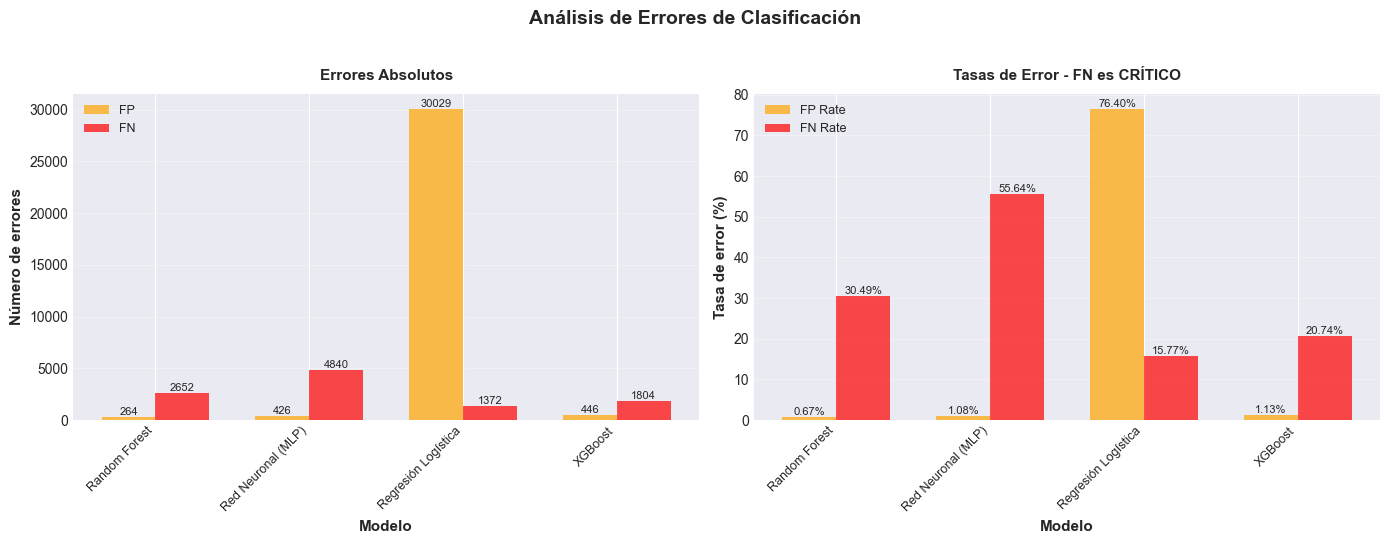

Gráfico de análisis de errores guardado en: outputs/error_analysis.png


In [143]:
# Visualización específica de errores
fig, axes = plt.subplots(1, 2, figsize=(14, 5.5))
fig.suptitle('Análisis de Errores de Clasificación', fontsize=14, fontweight='bold', y=0.98)

models = [m['model'] for m in all_metrics]
colors = ['#3498db', '#e74c3c', '#2ecc71']

# Gráfico 1: Valores absolutos de errores
fp_values = [m['fp'] for m in all_metrics]
fn_values = [m['fn'] for m in all_metrics]

x = np.arange(len(models))
width = 0.35

bars1 = axes[0].bar(x - width/2, fp_values, width, label='FP', 
                    color='orange', alpha=0.7)
bars2 = axes[0].bar(x + width/2, fn_values, width, label='FN', 
                    color='red', alpha=0.7)

axes[0].set_xlabel('Modelo', fontweight='bold', fontsize=11)
axes[0].set_ylabel('Número de errores', fontweight='bold', fontsize=11)
axes[0].set_title('Errores Absolutos', fontweight='bold', fontsize=11, pad=10)
axes[0].set_xticks(x)
axes[0].set_xticklabels(models, rotation=45, ha='right', fontsize=9)
axes[0].legend(loc='upper left', fontsize=9)
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_ylim(bottom=0)  # Empezar desde 0

# Añadir valores en las barras
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        axes[0].text(bar.get_x() + bar.get_width()/2., height,
                    f'{int(height)}',
                    ha='center', va='bottom', fontsize=8)

# Gráfico 2: Tasas de error (%)
fp_rates = [m['fp_rate'] for m in all_metrics]
fn_rates = [m['fn_rate'] for m in all_metrics]

bars3 = axes[1].bar(x - width/2, fp_rates, width, label='FP Rate', 
                    color='orange', alpha=0.7)
bars4 = axes[1].bar(x + width/2, fn_rates, width, label='FN Rate', 
                    color='red', alpha=0.7)

axes[1].set_xlabel('Modelo', fontweight='bold', fontsize=11)
axes[1].set_ylabel('Tasa de error (%)', fontweight='bold', fontsize=11)
axes[1].set_title('Tasas de Error - FN es CRÍTICO', fontweight='bold', fontsize=11, pad=10)
axes[1].set_xticks(x)
axes[1].set_xticklabels(models, rotation=45, ha='right', fontsize=9)
axes[1].legend(loc='upper left', fontsize=9)
axes[1].grid(axis='y', alpha=0.3)
axes[1].set_ylim(bottom=0)  # Empezar desde 0

# Añadir valores en las barras
for bars in [bars3, bars4]:
    for bar in bars:
        height = bar.get_height()
        axes[1].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.2f}%',
                    ha='center', va='bottom', fontsize=8)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('outputs/error_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("Gráfico de análisis de errores guardado en: outputs/error_analysis.png")


### Comparación Visual de Métricas

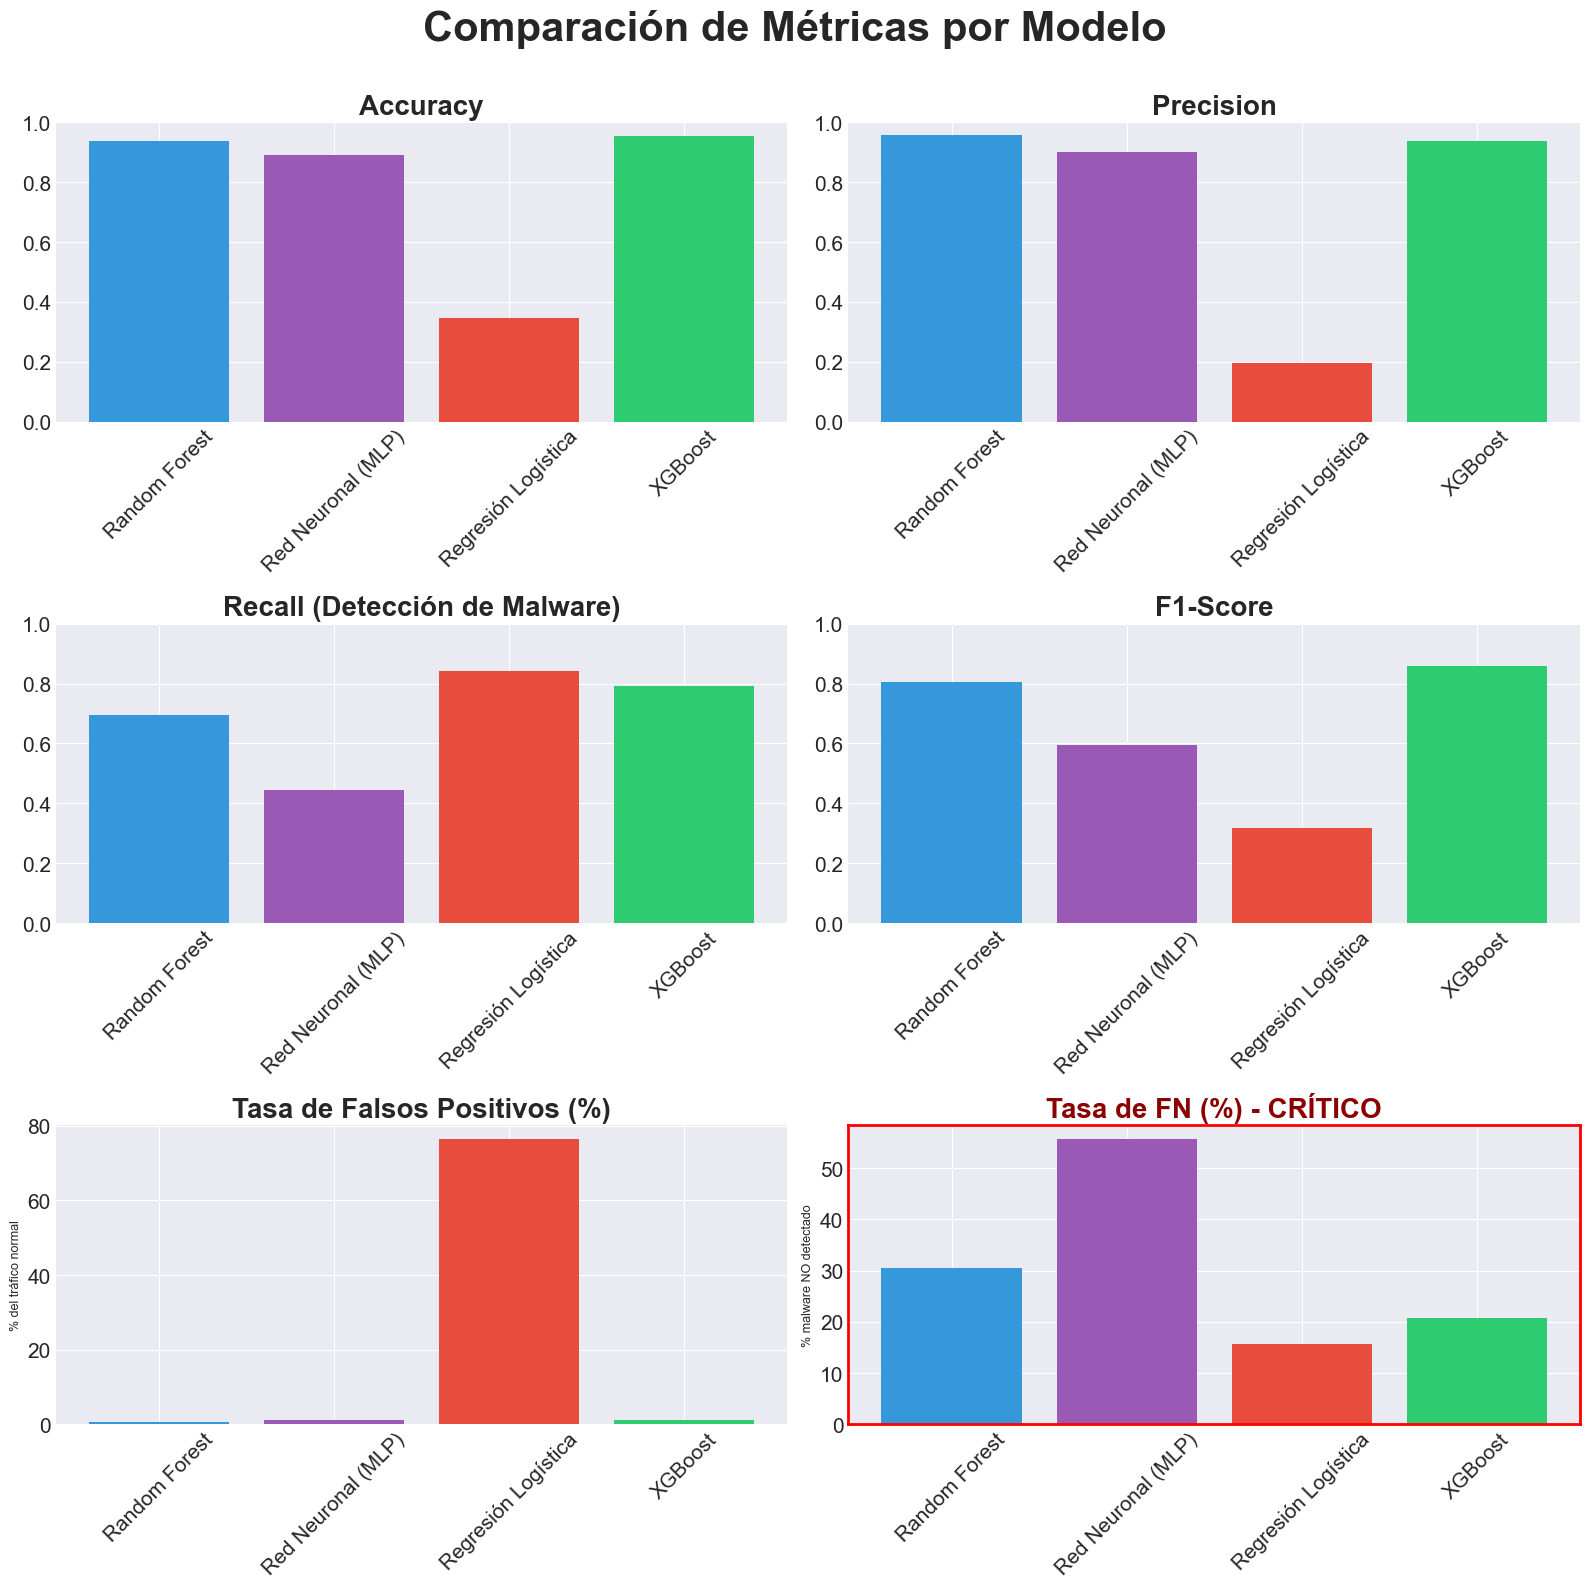

Gráfico de comparación guardado en: outputs/metrics_comparison.png


In [158]:
# Gráfico de barras comparativo
fig, axes = plt.subplots(3, 2, figsize=(16, 16))
fig.suptitle('Comparación de Métricas por Modelo', fontsize=30, fontweight='bold', y=0.99)

models = [m['model'] for m in all_metrics]
colors = ['#3498db', '#9b59b6', '#e74c3c', '#2ecc71']

# Accuracy -> proporción de predicciones correctas sobre el total de predicciones.
accuracies = [m['accuracy'] for m in all_metrics]
axes[0, 0].bar(models, accuracies, color=colors)
axes[0, 0].set_title('Accuracy', fontweight='bold', fontsize=20)
axes[0, 0].set_ylim([0, 1.0])
axes[0, 0].tick_params(axis='x', rotation=45, labelsize=15)
axes[0, 0].tick_params(axis='y', labelsize=15)

# Precision -> proporción de verdaderos positivos entre todos los predichos como positivos.
precisions = [m['precision'] for m in all_metrics]
axes[0, 1].bar(models, precisions, color=colors)
axes[0, 1].set_title('Precision', fontweight='bold', fontsize=20)
axes[0, 1].set_ylim([0, 1.0])
axes[0, 1].tick_params(axis='x', rotation=45, labelsize=15)
axes[0, 1].tick_params(axis='y', labelsize=15)

# Recall -> proporción de verdaderos positivos entre todos los positivos reales. (MÁS IMPORTANTE para seguridad)
recalls = [m['recall'] for m in all_metrics]
axes[1, 0].bar(models, recalls, color=colors)
axes[1, 0].set_title('Recall (Detección de Malware)', fontweight='bold', fontsize=20)
axes[1, 0].set_ylim([0, 1.0])
axes[1, 0].tick_params(axis='x', rotation=45, labelsize=15)
axes[1, 0].tick_params(axis='y', labelsize=15)

# F1-Score -> media armónica entre precisión y recall.
f1s = [m['f1'] for m in all_metrics]
axes[1, 1].bar(models, f1s, color=colors)
axes[1, 1].set_title('F1-Score', fontweight='bold', fontsize=20)
axes[1, 1].set_ylim([0, 1.0])
axes[1, 1].tick_params(axis='x', rotation=45, labelsize=15)
axes[1, 1].tick_params(axis='y', labelsize=15)

# Tasa de Falsos Positivos (FP Rate)
fp_rates = [m['fp_rate'] for m in all_metrics]
axes[2, 0].bar(models, fp_rates, color=colors)
axes[2, 0].set_title('Tasa de Falsos Positivos (%)', fontweight='bold', fontsize=20)
axes[2, 0].set_ylabel('% del tráfico normal', fontsize=9)
axes[2, 0].set_ylim(bottom=0)
axes[2, 0].tick_params(axis='x', rotation=45, labelsize=15)
axes[2, 0].tick_params(axis='y', labelsize=15)

# Tasa de Falsos Negativos (FN Rate) - MÁS CRÍTICO
fn_rates = [m['fn_rate'] for m in all_metrics]
bars = axes[2, 1].bar(models, fn_rates, color=colors)
axes[2, 1].set_title('Tasa de FN (%) - CRÍTICO', fontweight='bold', color='darkred', fontsize=20)
axes[2, 1].set_ylabel('% malware NO detectado', fontsize=9)
axes[2, 1].set_ylim(bottom=0)
axes[2, 1].tick_params(axis='x', rotation=45, labelsize=15)
axes[2, 1].tick_params(axis='y', labelsize=15)

# Resaltar el gráfico de FN con borde rojo
for spine in axes[2, 1].spines.values():
    spine.set_edgecolor('red')
    spine.set_linewidth(2)

plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.savefig('outputs/metrics_comparison.png', dpi=800, bbox_inches='tight')
plt.show()

print("Gráfico de comparación guardado en: outputs/metrics_comparison.png")


### Análisis de IPs Detectadas como Malware

**¿Están los modelos detectando las IPs correctas?**

Vamos a analizar qué IPs están siendo marcadas como malware por cada modelo y compararlas con las IPs reales de bots del escenario.

In [145]:
real_malware_ips = known_bots[SCENARIO_NUMBER]

# Obtener el subset de test con sus IPs originales
X_test_with_index = X_test.copy()
y_test_series = pd.Series(y_test.values, index=X_test.index)

# Recuperar IPs del dataframe original (en el índice de test)
df_test = df.loc[X_test.index].copy()

print("\n" + "="*80)
print("IPs DE MALWARE REAL EN ESTE ESCENARIO")
print("="*80)
print(f"\nEscenario #{SCENARIO_NUMBER} - {scenario_info['bot_type']} botnet")
print(f"\nIPs de bots conocidas y su frecuencia en el dataset de pruebas (test):")
for ip in real_malware_ips:
    count = df_test['id.orig_h'].value_counts().get(ip, 0)
    print(f"  - {ip} → {count:,} flujos")
print("="*80 + "\n")


# Función para analizar IPs detectadas por cada modelo
def analyze_detected_ips(model, X_test_data, df_test_data, model_name, use_scaled=False, scaler_obj=None):
    # Predicciones
    if use_scaled and scaler_obj is not None:
        X_eval = scaler_obj.transform(X_test_data)
    else:
        X_eval = X_test_data
    
    y_pred = model.predict(X_eval)
    
    # Crear DataFrame con IPs y predicciones
    results_df = df_test_data[['id.orig_h']].copy()
    results_df['predicted'] = y_pred
    
    # Filtrar solo las predichas como malware (1)
    malware_predictions = results_df[results_df['predicted'] == 1]
    
    # Contar frecuencia de cada IP
    ip_counts = malware_predictions['id.orig_h'].value_counts().head(10)
    
    return ip_counts

# Función auxiliar para mostrar resultados de un modelo
def print_model_ip_analysis(model, model_name, use_scaled=False, scaler_obj=None):
    print("="*80)
    print(f"{model_name.upper()} - Top 10 IPs detectadas como MALWARE")
    print("="*80 + "\n")
    
    ip_counts = analyze_detected_ips(model, X_test, df_test, model_name, use_scaled, scaler_obj)
    
    if len(ip_counts) == 0:
        print("No se detectó ninguna IP como MALWARE\n")
        return
    
    for idx, (ip, count) in enumerate(ip_counts.items(), 1):
        is_bot = "[BOT REAL]" if ip in real_malware_ips else "[FALSO POSITIVO]"
        print(f"  {idx:2d}. {ip:20s} → {count:5d} flujos {is_bot}")
    
    # Resumen
    detected_bots = [ip for ip in ip_counts.index if ip in real_malware_ips]
    missed_bots = [ip for ip in real_malware_ips if ip not in ip_counts.index]
    
    print(f"\nResumen:")
    print(f"  - Bots reales detectados: {len(detected_bots)}/{len(real_malware_ips)}")
    if detected_bots:
        print(f"  - IPs detectadas: {', '.join(detected_bots)}")
    if missed_bots:
        print(f"  - IPs NO detectadas: {', '.join(missed_bots)}")

print("Funciones de análisis de IPs definidas correctamente")


IPs DE MALWARE REAL EN ESTE ESCENARIO

Escenario #9 - Neris botnet

IPs de bots conocidas y su frecuencia en el dataset de pruebas (test):
  - 147.32.84.165 → 618 flujos
  - 147.32.84.191 → 712 flujos
  - 147.32.84.192 → 1,210 flujos
  - 147.32.84.193 → 771 flujos
  - 147.32.84.204 → 1,104 flujos
  - 147.32.84.205 → 723 flujos
  - 147.32.84.206 → 419 flujos
  - 147.32.84.207 → 621 flujos
  - 147.32.84.208 → 1,051 flujos
  - 147.32.84.209 → 1,470 flujos

Funciones de análisis de IPs definidas correctamente


#### Random Forest - Top IPs Detectadas

In [146]:
print_model_ip_analysis(rf_model, 'Random Forest')

RANDOM FOREST - Top 10 IPs detectadas como MALWARE

   1. 147.32.84.209        →  1150 flujos [BOT REAL]
   2. 147.32.84.192        →   980 flujos [BOT REAL]
   3. 147.32.84.208        →   835 flujos [BOT REAL]
   4. 147.32.84.204        →   818 flujos [BOT REAL]
   5. 147.32.84.191        →   424 flujos [BOT REAL]
   6. 147.32.84.165        →   407 flujos [BOT REAL]
   7. 147.32.84.193        →   404 flujos [BOT REAL]
   8. 147.32.84.205        →   402 flujos [BOT REAL]
   9. 147.32.84.207        →   402 flujos [BOT REAL]
  10. 147.32.84.206        →   225 flujos [BOT REAL]

Resumen:
  - Bots reales detectados: 10/10
  - IPs detectadas: 147.32.84.209, 147.32.84.192, 147.32.84.208, 147.32.84.204, 147.32.84.191, 147.32.84.165, 147.32.84.193, 147.32.84.205, 147.32.84.207, 147.32.84.206


#### Red Neuronal (MLP) - Top IPs Detectadas

In [147]:
print_model_ip_analysis(mlp_model, 'Red Neuronal (MLP)', use_scaled=True, scaler_obj=scaler)

RED NEURONAL (MLP) - Top 10 IPs detectadas como MALWARE

   1. 147.32.84.209        →   902 flujos [BOT REAL]
   2. 147.32.84.192        →   725 flujos [BOT REAL]
   3. 147.32.84.208        →   666 flujos [BOT REAL]
   4. 147.32.84.204        →   611 flujos [BOT REAL]
   5. 147.32.84.207        →   199 flujos [BOT REAL]
   6. 147.32.84.193        →   190 flujos [BOT REAL]
   7. 147.32.84.191        →   189 flujos [BOT REAL]
   8. 147.32.84.205        →   169 flujos [BOT REAL]
   9. 147.32.84.165        →   143 flujos [BOT REAL]
  10. 147.32.84.59         →    94 flujos [FALSO POSITIVO]

Resumen:
  - Bots reales detectados: 9/10
  - IPs detectadas: 147.32.84.209, 147.32.84.192, 147.32.84.208, 147.32.84.204, 147.32.84.207, 147.32.84.193, 147.32.84.191, 147.32.84.205, 147.32.84.165
  - IPs NO detectadas: 147.32.84.206


#### Regresión Logística - Top IPs Detectadas

In [148]:
print_model_ip_analysis(lr_model, 'Regresión Logística', use_scaled=True, scaler_obj=scaler)

REGRESIÓN LOGÍSTICA - Top 10 IPs detectadas como MALWARE

   1. 147.32.84.59         →  7878 flujos [FALSO POSITIVO]
   2. 147.32.86.20         →  2510 flujos [FALSO POSITIVO]
   3. 147.32.84.118        →  2181 flujos [FALSO POSITIVO]
   4. 147.32.84.209        →  1371 flujos [BOT REAL]
   5. 147.32.86.17         →  1254 flujos [FALSO POSITIVO]
   6. 147.32.84.192        →  1068 flujos [BOT REAL]
   7. 147.32.84.204        →   963 flujos [BOT REAL]
   8. 147.32.84.208        →   918 flujos [BOT REAL]
   9. 147.32.86.194        →   902 flujos [FALSO POSITIVO]
  10. 147.32.84.193        →   633 flujos [BOT REAL]

Resumen:
  - Bots reales detectados: 5/10
  - IPs detectadas: 147.32.84.209, 147.32.84.192, 147.32.84.204, 147.32.84.208, 147.32.84.193
  - IPs NO detectadas: 147.32.84.165, 147.32.84.191, 147.32.84.205, 147.32.84.206, 147.32.84.207


#### XGBoost - Top IPs Detectadas

In [149]:
print_model_ip_analysis(xgb_model, 'XGBoost')

XGBOOST - Top 10 IPs detectadas como MALWARE

   1. 147.32.84.209        →  1266 flujos [BOT REAL]
   2. 147.32.84.192        →  1068 flujos [BOT REAL]
   3. 147.32.84.204        →   907 flujos [BOT REAL]
   4. 147.32.84.208        →   898 flujos [BOT REAL]
   5. 147.32.84.191        →   539 flujos [BOT REAL]
   6. 147.32.84.193        →   529 flujos [BOT REAL]
   7. 147.32.84.207        →   482 flujos [BOT REAL]
   8. 147.32.84.165        →   474 flujos [BOT REAL]
   9. 147.32.84.205        →   465 flujos [BOT REAL]
  10. 147.32.84.206        →   267 flujos [BOT REAL]

Resumen:
  - Bots reales detectados: 10/10
  - IPs detectadas: 147.32.84.209, 147.32.84.192, 147.32.84.204, 147.32.84.208, 147.32.84.191, 147.32.84.193, 147.32.84.207, 147.32.84.165, 147.32.84.205, 147.32.84.206


## 8 Feature Importance (Random Forest)

In [150]:
print("[6/6] Analizando importancia de características...\n")

# Extraer importancias
feature_importances = rf_model.feature_importances_
feature_names = X_train.columns

# Crear DataFrame
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importances
}).sort_values('importance', ascending=False)

print("="*80)
print("TOP 10 CARACTERÍSTICAS MÁS IMPORTANTES (Random Forest)")
print("="*80 + "\n")
print(feature_importance_df.head(10).to_string(index=False))

# Guardar
feature_importance_df.to_csv('outputs/feature_importances_full.csv', index=False)
print("\nImportancias guardadas en: outputs/feature_importances_full.csv")

[6/6] Analizando importancia de características...

TOP 10 CARACTERÍSTICAS MÁS IMPORTANTES (Random Forest)

      feature  importance
   orig_bytes    0.215521
    orig_pkts    0.168960
     duration    0.167654
orig_ip_bytes    0.139372
    resp_pkts    0.108937
   resp_bytes    0.101481
resp_ip_bytes    0.097901
 missed_bytes    0.000173
     ip_proto    0.000000

Importancias guardadas en: outputs/feature_importances_full.csv


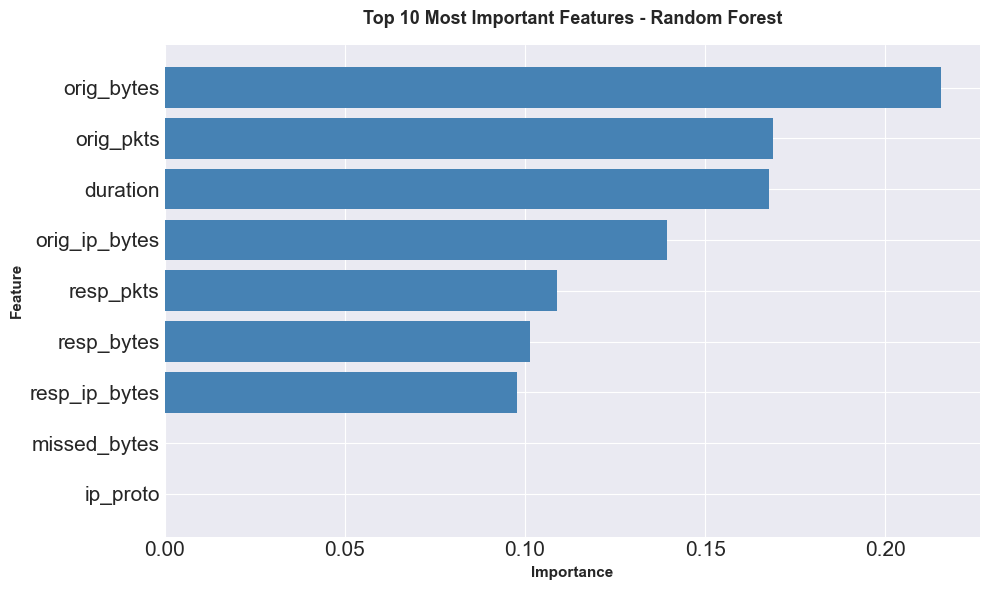

Gráfico guardado en: outputs/feature_importance.png


In [ ]:
# Visualizar importancia de características
top_n = 10
top_features = feature_importance_df.head(top_n)

plt.figure(figsize=(10, 6))
plt.barh(top_features['feature'], top_features['importance'], color='steelblue')
plt.xlabel('Importance', fontsize=11, fontweight='bold')
plt.ylabel('Feature', fontsize=11, fontweight='bold')
plt.title(f'Top {top_n} Most Important Features - Random Forest', 
         fontsize=13, fontweight='bold', pad=15)
plt.xlim(left=0)
plt.gca().invert_yaxis()
plt.tick_params(labelsize=15)
plt.tight_layout()
plt.savefig('outputs/feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

print("Gráfico guardado en: outputs/feature_importance.png")

## 9 Interpretación de Features

In [152]:
print("\n" + "="*80)
print("INTERPRETACIÓN DE TOP 3 CARACTERÍSTICAS")
print("="*80 + "\n")

top_3 = feature_importance_df.head(3)

interpretations = {
    'orig_bytes': "Bytes enviados por el origen - Bots envían patrones específicos",
    'resp_bytes': "Bytes recibidos del destino - Respuestas de C&C tienen tamaños característicos",
    'duration': "  Duración de conexión - Bots tienen conexiones muy cortas o muy largas",
    'orig_pkts': " Paquetes enviados - Escaneos generan muchos paquetes",
    'resp_pkts': " Paquetes recibidos - Tráfico legítimo tiene más respuestas",
    'orig_ip_bytes': " Bytes totales IP origen - Incluye headers, útil para detectar túneles",
    'resp_ip_bytes': " Bytes totales IP destino - Ayuda a identificar exfiltración"
}

for i, (idx, row) in enumerate(top_3.iterrows(), 1):
    feature = row['feature']
    importance = row['importance']
    interpretation = interpretations.get(feature, "Feature relevante para la clasificación")
    
    print(f"{i}. {feature}")
    print(f"   Importancia: {importance:.4f} ({importance*100:.2f}%)")
    print(f"   {interpretation}")
    print()


INTERPRETACIÓN DE TOP 3 CARACTERÍSTICAS

1. orig_bytes
   Importancia: 0.2155 (21.55%)
   Bytes enviados por el origen - Bots envían patrones específicos

2. orig_pkts
   Importancia: 0.1690 (16.90%)
    Paquetes enviados - Escaneos generan muchos paquetes

3. duration
   Importancia: 0.1677 (16.77%)
     Duración de conexión - Bots tienen conexiones muy cortas o muy largas



## Conclusiones Finales

In [153]:
print("\n" + "="*80)
print(f" RESUMEN Y CONCLUSIONES - Escenario CTU-13 #{SCENARIO_NUMBER}")
print("="*80 + "\n")

print(f" DATASET: {scenario_info['bot_type']} botnet ({scenario_info['num_bots']} bot(s))")
print(f"   └─ Dataset completo: {scenario_info['total']:,} flujos")
print(f"   └─ Botnet real: {scenario_info['botnet']:,} ({scenario_info['botnet']/scenario_info['total']*100:.2f}%)")

# Mejor modelo por recall
best_recall = max(all_metrics, key=lambda x: x['recall'])
print(f"\n MODELO RECOMENDADO: {best_recall['model']}")
print(f"   └─ Recall: {best_recall['recall']:.4f} (detecta {best_recall['recall']*100:.2f}% del malware)")
print(f"   └─ Falsos Positivos: {best_recall['fp']} ({best_recall['fp_rate']:.2f}% del tráfico normal)")
print(f"   └─ Falsos Negativos: {best_recall['fn']} ({best_recall['fn_rate']:.2f}% del malware NO detectado)")
print(f"   └─ F1-Score: {best_recall['f1']:.4f}")
print(f"   └─ Precision: {best_recall['precision']:.4f}")
print(f"   └─ Accuracy: {best_recall['accuracy']:.4f}")

print("\n" + "─"*80)
print(" RANKING DE MODELOS (por Recall):")
sorted_models = sorted(all_metrics, key=lambda x: x['recall'], reverse=True)
for i, m in enumerate(sorted_models, 1):
    print(f"   {i}. {m['model']:20s} - Recall: {m['recall']:.4f} | FN: {m['fn']} ({m['fn_rate']:.2f}%)")

print("\n" + "─"*80)
print(" ARCHIVOS GENERADOS:")
print("   • metrics_comparison.csv - Tabla comparativa de métricas")
print("   • feature_importances_full.csv - Importancias de todas las features")
print("   • confusion_matrices.png - Matrices de confusión")
print("   • error_analysis.png - Análisis de errores (FP/FN)")
print("   • feature_importance.png - Gráfico de importancia")
print("   • metrics_comparison.png - Comparación visual de métricas")

print("\n" + "="*80)
print(" ANÁLISIS COMPLETADO EXITOSAMENTE")
print("="*80)


 RESUMEN Y CONCLUSIONES - Escenario CTU-13 #9

 DATASET: Neris botnet (10 bot(s))
   └─ Dataset completo: 2,753,884 flujos
   └─ Botnet real: 179,880 (6.53%)

 MODELO RECOMENDADO: Regresión Logística
   └─ Recall: 0.8423 (detecta 84.23% del malware)
   └─ Falsos Positivos: 30029 (76.40% del tráfico normal)
   └─ Falsos Negativos: 1372 (15.77% del malware NO detectado)
   └─ F1-Score: 0.3182
   └─ Precision: 0.1961
   └─ Accuracy: 0.3459

────────────────────────────────────────────────────────────────────────────────
 RANKING DE MODELOS (por Recall):
   1. Regresión Logística  - Recall: 0.8423 | FN: 1372 (15.77%)
   2. XGBoost              - Recall: 0.7926 | FN: 1804 (20.74%)
   3. Random Forest        - Recall: 0.6951 | FN: 2652 (30.49%)
   4. Red Neuronal (MLP)   - Recall: 0.4436 | FN: 4840 (55.64%)

────────────────────────────────────────────────────────────────────────────────
 ARCHIVOS GENERADOS:
   • metrics_comparison.csv - Tabla comparativa de métricas
   • feature_importance

## Guardar Modelos

In [154]:
# Guardar modelos entrenados
import pickle

with open('models/random_forest_model.pkl', 'wb') as f:
    pickle.dump(rf_model, f)

with open('models/mlp_model.pkl', 'wb') as f:
    pickle.dump(mlp_model, f)

with open('models/xgboost_model.pkl', 'wb') as f:
    pickle.dump(xgb_model, f)

with open('models/logistic_regression_model.pkl', 'wb') as f:
    pickle.dump(lr_model, f)

with open('models/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print("Modelos guardados:")
print("   • random_forest_model.pkl")
print("   • mlp_model.pkl (Red Neuronal)")
print("   • xgboost_model.pkl")
print("   • logistic_regression_model.pkl")
print("   • scaler.pkl")

Modelos guardados:
   • random_forest_model.pkl
   • mlp_model.pkl (Red Neuronal)
   • xgboost_model.pkl
   • logistic_regression_model.pkl
   • scaler.pkl
